<a href="https://colab.research.google.com/github/Tajyu/TensorFlow-Tutotrial/blob/main/CNN%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN**이란 원본 이니지의 각 픽셀을 포함한 주변 픽셀과 필터의 모든 픽셀을 각각 곱연산을 하고, 그 결과를 합해서 새로운 이미지에 넣어준다.

## 크게 2가지로 나눌수있으며,
## ① Feature Extractor: 특징 정보를 추출하며, Convolution Layers + Pooling Layers해서 사용
## ② Classifier(분류): Fully Connected Layers = Dense Layers + Dropout Layers로 구성

## - Convolution Layers: Input image에서 특징을 추출하는 역할
## - Pooling Layers: 중요한 정보만 남기고 계산 부담을 줄여주는 역할
## - Dropout Layers: 과적합을 방지하는 역할

## Convolution Layer
### - 컨볼루션 연산을 하는 레이어 (필터를 자동으로 추출한다.)
## -----------------------------------------------------------------------------------
### ex) layers.Conv2D(kernel_size = (3, 3), strides = (2, 2), padding = "valid", fiters = 16
### - kernel_size: 필터 행렬의 크기
### - strides: 필터 한 스텝 이동하는 크기 ex) (1,1), (2, 2), ...
### - padding: 이미지 주변에 빈 값을 넣을지 지정하는 옵션 
### -> "valid(빈 값 사용X)"와 "same(빈 값 사용O => 0으로 쓰는경우 zero padding)"
### - filter: 필터의 개수 (너무 많으면 학습 속도가 느려질 수 있고, 과적합 발생 할 수도 있다.


## CNN에서 유명한 필터:
### - VGG: 네트워크가 깊어질수록 필터 2배씩 증가 ex) (64 -> 128 -> 256 -> 512)

## Pooling Layer
## - 이미지 크기를 줄이면서 중요한 정보만 남기기 위해서 subsampling하는 기법
## -> 계산할 정보가 줄어서 오버피팅을 방지한다.
### ----------------------------------------------------------------------------------------------
### - Average Pooling
### - Max Pooling
### ex) layers.MaxPool2D(pool_size = (2,2), strides = (2, 2))
### - pool_size: (2, 2) 행렬 안에서 최댓값만 남긴다.
### - strides: 컨볼루션과 마찬가지로 한 스텝마다 이동하는 크기
### -> 위 옵션으로 사용하면 이미지크기가 절반으로 줄어든다.

## Dense Layer
### ex) layers.Dense(unit = 정수, activation = "relu or softmax ...", None)  
### ex) layers.Dense(unit = 정수, activation = "relu or softmax ...", input_shape(x, y, z) ...)  

## Dropout Layer
### - 네트워크의 오버피팅을 막기위해 사용.
### - 학습과정에서 무작위로 뉴런의 부분집합을 제거
### - 학습과정에서는 확률적으로 일부 뉴런 연결을 끊고, 테스트시에는 모든 값을  포함해서 계산한다.
### ex) layers.Dropout(rate = 0.3)
### - rate: 제외할 뉴런의 비율

## Inputs -> Convolution -> Pooling -> Dense -> ...

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## MNIST 데이세트 다운로드하고 준비하기

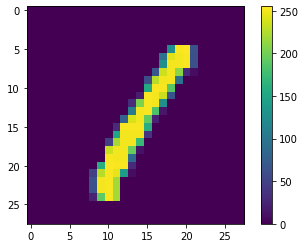

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

## reshape을 써야하는 이유: 데이터를 구성하는 이미지가 흑백(1채널), RGB(3채널)을 가지도록 데이터 shape으로 변경해줘야함.
## 아래는 MNIST 데이터로 흑백 이미지라서 마지막에 **"1"**로 작성

In [ ]:
# Conv2D 채널을 가진 형태로 변경을 해야 한다.
# 데이터를 구성하는 이미지의 형태별로 마지막 값이 변경된다.(1 (흑백) or 3 (칼라))
# 이미지의 형태에 맞도록 채널을 가지게 하기위하여 데이터 shape을 변경 해야해서 "reshape"을 한다.
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# 픽셀 값을 0 ~ 1 사이로 정규화한다.
train_images, test_images = train_images / 255.0, test_images / 255.0 # 0 ~ 255 사이에 값이 있기 떄문에 255.0 으로 나누어 0 ~ 1로 바꿔준다.

In [ ]:
plt.figure()
# reshape()을 하여 3차원 데이터를 2차원 데이터로 변환.
plt.imshow(train_images[7].reshape(28,28))
plt.colorbar()
plt.grid(False) # gird(): 격자
plt.show()

## 합성곱 층 만들기
### 아래 6줄의 코드에서 **Conv2D**와 **MaxPooling2D** 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의한다.
### **CNN**은 배치(batch) 크기를 제외하고 (이미지 높이, 이미지 너비, 컬러 채널) 크기의 텐서(tensor)를 입력으로 받는다.
### **MNIST 데이터**는 (**흑백 이미지이기 떄문에**) **컬러 채널(channel)이 하나**지만 **컬러 이미지는(R, G, B) 세 개의 채널을 가진다.**
### 이 예에서는 **MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하는 CNN을 정의**한다.
### 이 값을 첫 번쨰 층의 **input_shape** 매개변수로 전달한다.

In [ ]:
model = models.Sequential()
# Conv2D와 MaxPooling2D로 층을 쌓는다.
# Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서
# relu의 성능이 좋아서 보편적으로 사용한다.
model.add(layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (28, 28, 1))) # 28 x 28 픽셀, 1개의 채널
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = "relu"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


### 위에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서이다. 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가진다.
### Conv2D 층에서 출력 채널의 수는 첫 번쨰 매개변수에 의해 결정된다.(예를들면, 32 또는 64)
### 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있다. 

## 마지막에 Dense 층 추가하기

### 모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (3, 3, 64))를 하나 이상의 Dense층에 주입하여 분류를 수행한다.
### Dense층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서이다.
### 먼저 3D 출력을 1D로 펼친다. 그다음 하나 이상의 Dense층을 그 위에 추가한다.
### MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용한다.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dense(10, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

### 여기에서 볼 수 있듯이 두 개의 Dense 층을 통과하기 전에 (3, 3, 64) 출력을 (576) 크기의 벡터로 펼친다.
### 3(높이) * 3(너비) * 64(채널) = 576

In [ ]:
# 기본 이미지 분류에서 쌓았던 방식
# model = keras.Sequential([
#                           keras.layers.Flatten(input_shape = (28, 28)),
#                           keras.layers.Dense(128, activation = "relu0"),
#                           keras.layers.Dense(10, activation = "softmax")
# ])

In [ ]:
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

model.fit(train_images, train_labels, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 39s 6ms/step - loss: 0.1447 - accuracy: 0.9553
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0462 - accuracy: 0.9853
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0329 - accuracy: 0.9898
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0260 - accuracy: 0.9916
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0203 - accuracy: 0.9932
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0175 - accuracy: 0.9945
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0134 - accuracy: 0.9955
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0116 - accuracy: 0.9961
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0106 - accuracy: 0.9965
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

### **"optimizer"**의 종류

In [ ]:
from keras import optimizers
dir(optimizers)

## 모델 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)

313/313 - 1s - loss: 0.0332 - accuracy: 0.9917
